In [1]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers
!pip install torch

In [2]:
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-q3z0dd8x/kobert-tokenizer_9a55bdc37f1a4110b8e38683ef7617f4
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-q3z0dd8x/kobert-tokenizer_9a55bdc37f1a4110b8e38683ef7617f4
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 5c46b1c68e4755b54879431bd302db621f4d2f47
  Preparing metadata (setup.py) ... done


In [3]:
import pandas as pd
import numpy as np
import urllib.request
import os
from tqdm import tqdm
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt",filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')
data=pd.read_csv('/content/drive/MyDrive/비긴어게인_movei_sentiment.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7493 entries, 0 to 7492
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  7493 non-null   int64  
 1   star        7493 non-null   int64  
 2   reviews     7493 non-null   object 
 3   sentiment   7490 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 234.3+ KB


In [4]:
print(len(train_data))
print(len(test_data))
df=pd.concat([train_data,test_data])
df.info()

150000
50000
<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        200000 non-null  int64 
 1   document  199992 non-null  object
 2   label     200000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 6.1+ MB


In [5]:
begin_again_review=data.drop(['star'],axis=1)
begin_again_review=begin_again_review.rename(columns={'reviews':'document','sentiment':'label','Unnamed: 0':'id'})
begin_again_review=begin_again_review.dropna(how='any')
begin_again_review.info()
# Convert the 'label' column in DataFrame data_1 to integers
begin_again_review['label'] = begin_again_review['label'].astype(int)
begin_again_review

<class 'pandas.core.frame.DataFrame'>
Index: 7490 entries, 0 to 7492
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        7490 non-null   int64  
 1   document  7490 non-null   object 
 2   label     7490 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.1+ KB


,id,document,label
0,0,음악이 감정을 잘 살려준 영화,1
1,1,가을 날씨 뉴욕의 풍경 아름다운 음악들 10년만에 다시 봐도 여전히 좋다,1
2,2,다시봐도 참 좋은 작품이에요,1
3,3,모든장면들과 들의 조화가 아름답다,1
4,4,요즘 날씨에 보기 좋은 영화예요,1
...,...,...,...
7488,7488,원스보다 노래가 다양하지 않지만 굳,1
7489,7489,요즘음반시장에색다른모습에잘봤네요,1
7490,7490,일단 원스보단 훨씬 재밌고 노래도 좋아요,1
7491,7491,노래 너무 좋은 것 같아요,1


In [6]:
df.drop_duplicates(subset=['document'], inplace=True) # document 열 에 서 중복인 내용이 있다면 중복 제거
df = df.dropna(how='any') # Null 값 이 존 재 하 는 행 제 거 3 print(' 훈 련 데 이 터 의 리 뷰 수 :',len(train_data))

df=df.dropna(how='any')
print('테스트 리뷰 수: ',len(df))

테스트 리뷰 수:  194543


In [7]:
df.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 194543 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        194543 non-null  int64 
 1   document  194543 non-null  object
 2   label     194543 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 5.9+ MB


In [9]:
import torch
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertForSequenceClassification
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# 모든 경고 무시
warnings.simplefilter("ignore")

# 시드 설정 (재현 가능성 보장)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# CUDA가 사용 가능한 경우 GPU를 사용하고, 그렇지 않으면 CPU를 사용합니다.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 현재 사용 중인 장치 출력 (예: cuda:0 또는 cpu)
print(f"Using device: {device}")

# KoBERT 모델과 토크나이저 로드
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
model = BertForSequenceClassification.from_pretrained('skt/kobert-base-v1', num_labels=2)

# GPU 사용 설정
model.to(device)

# 모델 저장 경로 설정
model_save_path = "best_kobert_model.pt"

Using device: cuda


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at skt/kobert-base-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# 토크나이저의 사전 크기 확인
vocab_size = tokenizer.vocab_size
print(f"KoBERT 토크나이저의 단어 사전 크기: {vocab_size}")

# 토크나이저의 전체 사전 확인
vocab = tokenizer.get_vocab()

# 일부만 출력해보기 (앞에서 10개만)
print(f"KoBERT 토크나이저의 단어 사전 중 일부: {list(vocab.items())[:10]}")

KoBERT 토크나이저의 단어 사전 크기: 8002
KoBERT 토크나이저의 단어 사전 중 일부: [('[UNK]', 0), ('[PAD]', 1), ('[CLS]', 2), ('[SEP]', 3), ('[MASK]', 4), ('!', 5), ("!'", 6), ('!”', 7), ('"', 8), ('#', 9)]


In [11]:
# 예시 문장
text = ["이 영화 정말 재미있어요!", "이 영화 정말 정말 재미없네요"]

# 토큰화 및 텐서로 변환
encoding = tokenizer(
    text,
    truncation=True,         # 최대 길이보다 긴 문장은 자름
    padding='max_length',    # 최대 길이만큼 패딩 추가
    max_length=128,           # 최대 길이 10으로 설정
    return_tensors='pt'      # PyTorch 텐서 형식으로 반환
)

# input_ids와 attention_mask 출력
input_ids = encoding['input_ids'].squeeze()        # input_ids (토큰 ID)
attention_mask = encoding['attention_mask'].squeeze()  # attention_mask (유효한 토큰 1, 패딩 0)
token_type_ids = encoding['token_type_ids'].squeeze()  # token_type_ids (문장 1: 0, 문장 2: 1)

print(f"input sequence: {text}")
print(f"Input IDs: {input_ids}")
print(f"Attention Mask: {attention_mask}")
print(f"Token Type IDs: {token_type_ids}")

input sequence: ['이 영화 정말 재미있어요!', '이 영화 정말 정말 재미없네요']
Input IDs: tensor([[   2, 3647, 3394, 4102, 3978, 6857,    5,    3,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1],
        [   2, 3647, 3394, 4102, 4102, 3977, 6881, 5703,    3,    

In [12]:
#  전체 데이터셋의 10%만 사용
train_data, val_data = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=42)

# 데이터셋을 8:1:1 비율로 나누기 (80% train, 10% validation, 10% test)
# val_data, test_data = train_test_split(test_data, test_size=0.5, stratify=test_data['label'], random_state=42)
# val_data, test_data = train_test_split(train_data, test_size=0.5, stratify=temp_data['label'], random_state=42)

In [13]:
df['label'].value_counts(normalize=True).round(2)

,proportion
label,
0,0.5
1,0.5


In [14]:
train_data['label'].value_counts(normalize=True).round(2)
val_data['label'].value_counts(normalize=True).round(2)

,proportion
label,
0,0.5
1,0.5


In [15]:
# 데이터셋을 커스텀 Dataset 클래스로 변환
class MRDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['document']
        label = self.data.iloc[idx]['label']

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': torch.tensor(label, dtype=torch.long)
        }

In [16]:
# Dataset 클래스를 사용하여 데이터셋 생성
train_dataset = MRDataset(train_data, tokenizer)
val_dataset = MRDataset(val_data, tokenizer)
test_dataset = MRDataset(begin_again_review, tokenizer)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [17]:
first_batch = next(iter(train_loader))
first_batch

{'input_ids': tensor([[   2, 3969, 6269,  ...,    1,    1,    1],
         [   2, 1907, 7220,  ...,    1,    1,    1],
         [   2, 4841, 7220,  ...,    1,    1,    1],
         ...,
         [   2, 5090, 6424,  ...,    1,    1,    1],
         [   2,  538, 5283,  ...,    1,    1,    1],
         [   2, 4102, 2420,  ...,    1,    1,    1]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'label': tensor([1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,
         1, 1, 1, 1, 1, 1, 1, 1])}

In [18]:
print(f"input_ids shape : {first_batch['input_ids'].shape}, \n\
attention_mask shape : {first_batch['attention_mask'].shape} \n\
label shape : {first_batch['label'].shape}")

input_ids shape : torch.Size([32, 128]), 
attention_mask shape : torch.Size([32, 128]) 
label shape : torch.Size([32])


In [19]:
# 학습 루프 정의
def train_epoch(model, data_loader, optimizer):
    model.train()
    total_loss = 0
    for batch in tqdm(data_loader, desc="Training"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels) # labels=labels옵션을 넣게 되면 loss를 자동으로 계산이 가능함
        loss = outputs.loss # label이 주어졌을 때 자동으로 loss를 계산
        loss.backward()  # Backward pass
        optimizer.step()
        # scheduler.step()

        total_loss += loss.item()
    return total_loss / len(data_loader)

def evaluate(model, data_loader):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    preds_list = []
    labels_list = []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1) # 텐서의 마지막 차원에서 가장 큰 확률 값의 인덱스를 반환

            correct_predictions += (preds == labels).sum().item()
            total_samples += labels.size(0) # labels.size(0)는 batch size
            total_loss += loss.item()

            # 예측 및 실제 레이블을 저장하여 나중에 사용
            preds_list.extend(preds.cpu().numpy())
            labels_list.extend(labels.cpu().numpy())

    accuracy = correct_predictions / total_samples
    return accuracy, total_loss / len(data_loader), preds_list, labels_list

In [20]:
# 옵티마이저 설정 및 학습 실행
optimizer = AdamW(model.parameters(), lr=5e-5)
EPOCHS = 3 # max_len=128, batch=32
best_val_accuracy = 0  # 최고 검증 정확도 초기화

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")

    # Train
    # train_loss = train_epoch(model, train_loader, optimizer)
    train_loss = train_epoch(model, train_loader, optimizer)
    print(f"Train Loss: {train_loss:.4f}")

    # Validation
    val_accuracy, val_loss, _, _ = evaluate(model, val_loader)
    print(f"Validation Accuracy: {val_accuracy:.4f}, Validation Loss: {val_loss:.4f}")

    # 검증 정확도가 개선되면 모델 저장
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), model_save_path)
        print(f"Model saved at epoch {epoch + 1} with validation accuracy: {val_accuracy:.4f}")

Epoch 1/3


Training: 100%|██████████| 5472/5472 [15:04<00:00,  6.05it/s]


Train Loss: 0.3186


Evaluating: 100%|██████████| 608/608 [00:38<00:00, 15.67it/s]


Validation Accuracy: 0.8880, Validation Loss: 0.2691
Model saved at epoch 1 with validation accuracy: 0.8880
Epoch 2/3


Training: 100%|██████████| 5472/5472 [15:03<00:00,  6.06it/s]


Train Loss: 0.2372


Evaluating: 100%|██████████| 608/608 [00:38<00:00, 15.69it/s]


Validation Accuracy: 0.8969, Validation Loss: 0.2647
Model saved at epoch 2 with validation accuracy: 0.8969
Epoch 3/3


Training: 100%|██████████| 5472/5472 [15:03<00:00,  6.06it/s]


Train Loss: 0.2166


Evaluating: 100%|██████████| 608/608 [00:38<00:00, 15.69it/s]

Validation Accuracy: 0.4995, Validation Loss: 0.6930


In [21]:
# 저장된 모델 로드
print(f"Loading best model from {model_save_path}")
model.load_state_dict(torch.load(model_save_path))

Loading best model from best_kobert_model.pt


<All keys matched successfully>

In [22]:
# 테스트 데이터로 평가 및 혼동행렬 출력
test_accuracy, test_loss, test_preds, test_labels = evaluate(model, test_loader)

Evaluating: 100%|██████████| 235/235 [00:14<00:00, 15.95it/s]


Test Accuracy: 0.9414
Test Loss: 0.1615
Confusion Matrix:
[[ 492  236]
 [ 203 6559]]


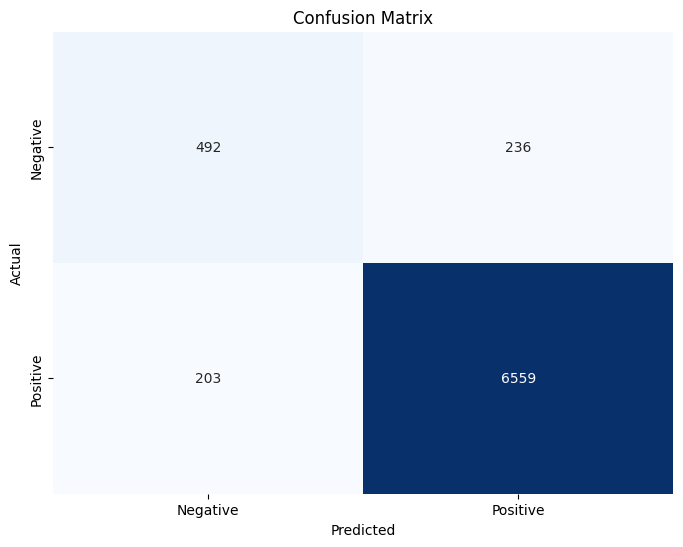

In [23]:
# 혼동행렬 계산 및 출력
conf_matrix = confusion_matrix(test_labels, test_preds)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [24]:
import torch.nn.functional as F

# 테스트 예시: 새로운 문장을 넣어서 예측
def predict(text, model, tokenizer, device):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=128)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=-1).cpu().item() # 정수형태로 라벨 출력
        probabilities = F.softmax(logits, dim=-1) # logits softmax 적용
        positive_prob = probabilities[0][1].cpu().item() # 긍정 확률로 라벨 출력
    return positive_prob

# 예시 문장 예측
example_sentence = "재미있게 봤어요!"
prediction = predict(example_sentence, model, tokenizer, device)
print(f"예시 문장: '{example_sentence}'")
print(f"예측 결과: {prediction}")

예시 문장: '재미있게 봤어요!'
예측 결과: 0.9924654960632324


In [25]:
import torch.nn.functional as F
import pandas as pd

# 테스트 예시: 새로운 문장을 넣어서 예측
def predict(text, model, tokenizer, device):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=128)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        probabilities = F.softmax(logits, dim=-1)
        positive_prob = probabilities[0][1].cpu().item()  # 긍정 클래스의 확률

    return positive_prob

# 예시 문장 리스트
example_sentences = ["재미있게 봤어요!", "별로였어요.", "정말 훌륭했어요!"]
results = []

# 각 문장에 대해 예측 수행
for sentence in example_sentences:
    positive_probability = predict(sentence, model, tokenizer, device)
    results.append({"문장": sentence, "긍정 확률": positive_probability})

# 데이터프레임 생성
results_df = pd.DataFrame(results)

# 결과 출력
print(results_df)


          문장     긍정 확률
0  재미있게 봤어요!  0.992465
1     별로였어요.  0.007837
2  정말 훌륭했어요!  0.992387


In [26]:
results_df

,문장,긍정 확률
0,재미있게 봤어요!,0.992465
1,별로였어요.,0.007837
2,정말 훌륭했어요!,0.992387
